# Cascading Food Risks

## Imports

In [42]:
import pandas as pd
import networkx as nx
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from IPython.display import Image
from fuzzywuzzy import fuzz, process
import math
import pickle
import plotly
import plotly.express as px


%matplotlib inline

## Functions

In [124]:
with open('../data/country_centroid_lookup.pickle', 'rb') as handle:
    country_centroid_harvard_lookup = pickle.load(handle)
    country_centroids = pd.read_csv("http://worldmap.harvard.edu/download/wfs/34645/csv?outputFormat=csv&service=WFS&request=GetFeature&format_options=charset%3AUTF-8&typename=geonode%3Acountry_centroids_az8&version=1.0.0")
    country_centroid_manual_lookup = {row['name']: (row['Longitude'], row['Latitude']) for _, row in country_centroids.to_dict('index').items()}
    
with open('../data/iso_alpha_to_name.pickle', 'rb') as handle:
    iso_alpha_to_name = pickle.load(handle)
    name_to_iso_alpha =  {v: k for k, v in iso_alpha_to_name.items()}
    name_to_iso_alpha["CÃ´te d'Ivoire"] = 'CIV'
    name_to_iso_alpha["Democratic Republic of the Congo"] = 'COD'
    name_to_iso_alpha["Republic of Korea"] = 'KOR'
    name_to_iso_alpha["Republic of Moldova"] = 'MDA'
    name_to_iso_alpha["United Kingdom"] = 'GBR'
    name_to_iso_alpha["United Republic of Tanzania"] = 'TZA'
    name_to_iso_alpha["China, Hong Kong SAR"] = 'HKG'
    name_to_iso_alpha["China, Macao SAR"] = 'MAC'
    name_to_iso_alpha["China, Taiwan Province of"] = 'TWN'
    name_to_iso_alpha["China, mainland"] = 'CHN'
    name_to_iso_alpha["Democratic People's Republic of Korea"] = 'PRK'
    name_to_iso_alpha["British Virgin Islands"] = 'VGB'
    name_to_iso_alpha["Palestine"] = 'PSE'
    
    
def create_nx_edge_from_trade_row(row):
    if row.element == 'Import Quantity':
        return (row.partner, row.reporter)
    elif row.element == 'Export Quantity':
        return (row.reporter, row.partner)
    else:
        print(f'Unknown edge type: {row.element}')

        
def create_trade_graph(trade_data):

    G = nx.DiGraph()

    for i, row in trade_data.iterrows():
        
        proposed_edge = create_nx_edge_from_trade_row(row)

        if G.has_edge(*proposed_edge):
            G.add_edge(*proposed_edge, amount= (G.get_edge_data(*proposed_edge)['amount'] + row.value)/2)
        else:
            G.add_edge(*proposed_edge, amount=row.value)
    
    return G


def best_fuzzy_match(text, candidates):
    best = process.extractOne(text, candidates)
    return best[0]


def get_iso_alpha_from_country_name(name):
    if name in name_to_iso_alpha:
        return name_to_iso_alpha[name]
    else:
        print(name)
        return 'ABC'
    

def get_lon_lat_from_country_name(name):
    return country_centroid_harvard_lookup.get(name) or country_centroid_manual_lookup[name]

## Trade Graph Generation

In [79]:
trade_data = pd.read_csv("https://raw.githubusercontent.com/zutn/Trade-Reduction/master/trade_by_country_2017.csv", sep=";")

In [80]:
print(len(trade_data))

36771


In [81]:
trade_data.sample(4)

Reporter Countries         Partner Countries          Element  \
22979                Netherlands  Turks and Caicos Islands  Import Quantity   
33651                     Turkey                  Thailand  Export Quantity   
36636                     Zambia          Unspecified Area  Export Quantity   
6796   China, Taiwan Province of                     Kenya  Export Quantity   

         Y2017  
22979    277.0  
33651  32763.0  
36636    431.0  
6796      25.0

In [82]:
trade_data.columns = ['reporter', 'partner', 'element', 'value']
trade_data.sample(4)

reporter        partner          element    value
34642            United Kingdom  Côte d'Ivoire  Export Quantity  11993.0
35370  United States of America     Montenegro  Import Quantity    126.0
13140                    Greece         Belize  Export Quantity     14.0
3455                      Benin          Nepal  Export Quantity   3568.0

In [87]:
trade_graph = create_trade_graph(trade_data)

## Overall Trade Graph Visualisation

In [32]:
# To plot trade on a map, we first need the geographical coordinates of each country. For each unique country in our trade data, find it's 
# corresponding centroid using lookup tables from online + manually generated
pos = {country: get_lon_lat_from_country_name(country) for country in trade_data.partner.unique()}

In [33]:
# We'll make node size dependent on degree - i.e. number of trade connections
deg = nx.degree(trade_graph)
sizes = [2 * deg[country] for country in trade_graph.nodes]

In [34]:
# We'll make node size dependent on amount - i.e. volume of trade
amounts = [trade_graph[u][v]['amount'] for u,v in trade_graph.edges()]
max_amount = max(amounts)
weights = [max((50 * float(i)/max_amount), 0.005) for i in amounts]

In [35]:
# Display labels if at least 100 connections
labels = {country: country if deg[country] >= 200 else '' for country in trade_graph.nodes}

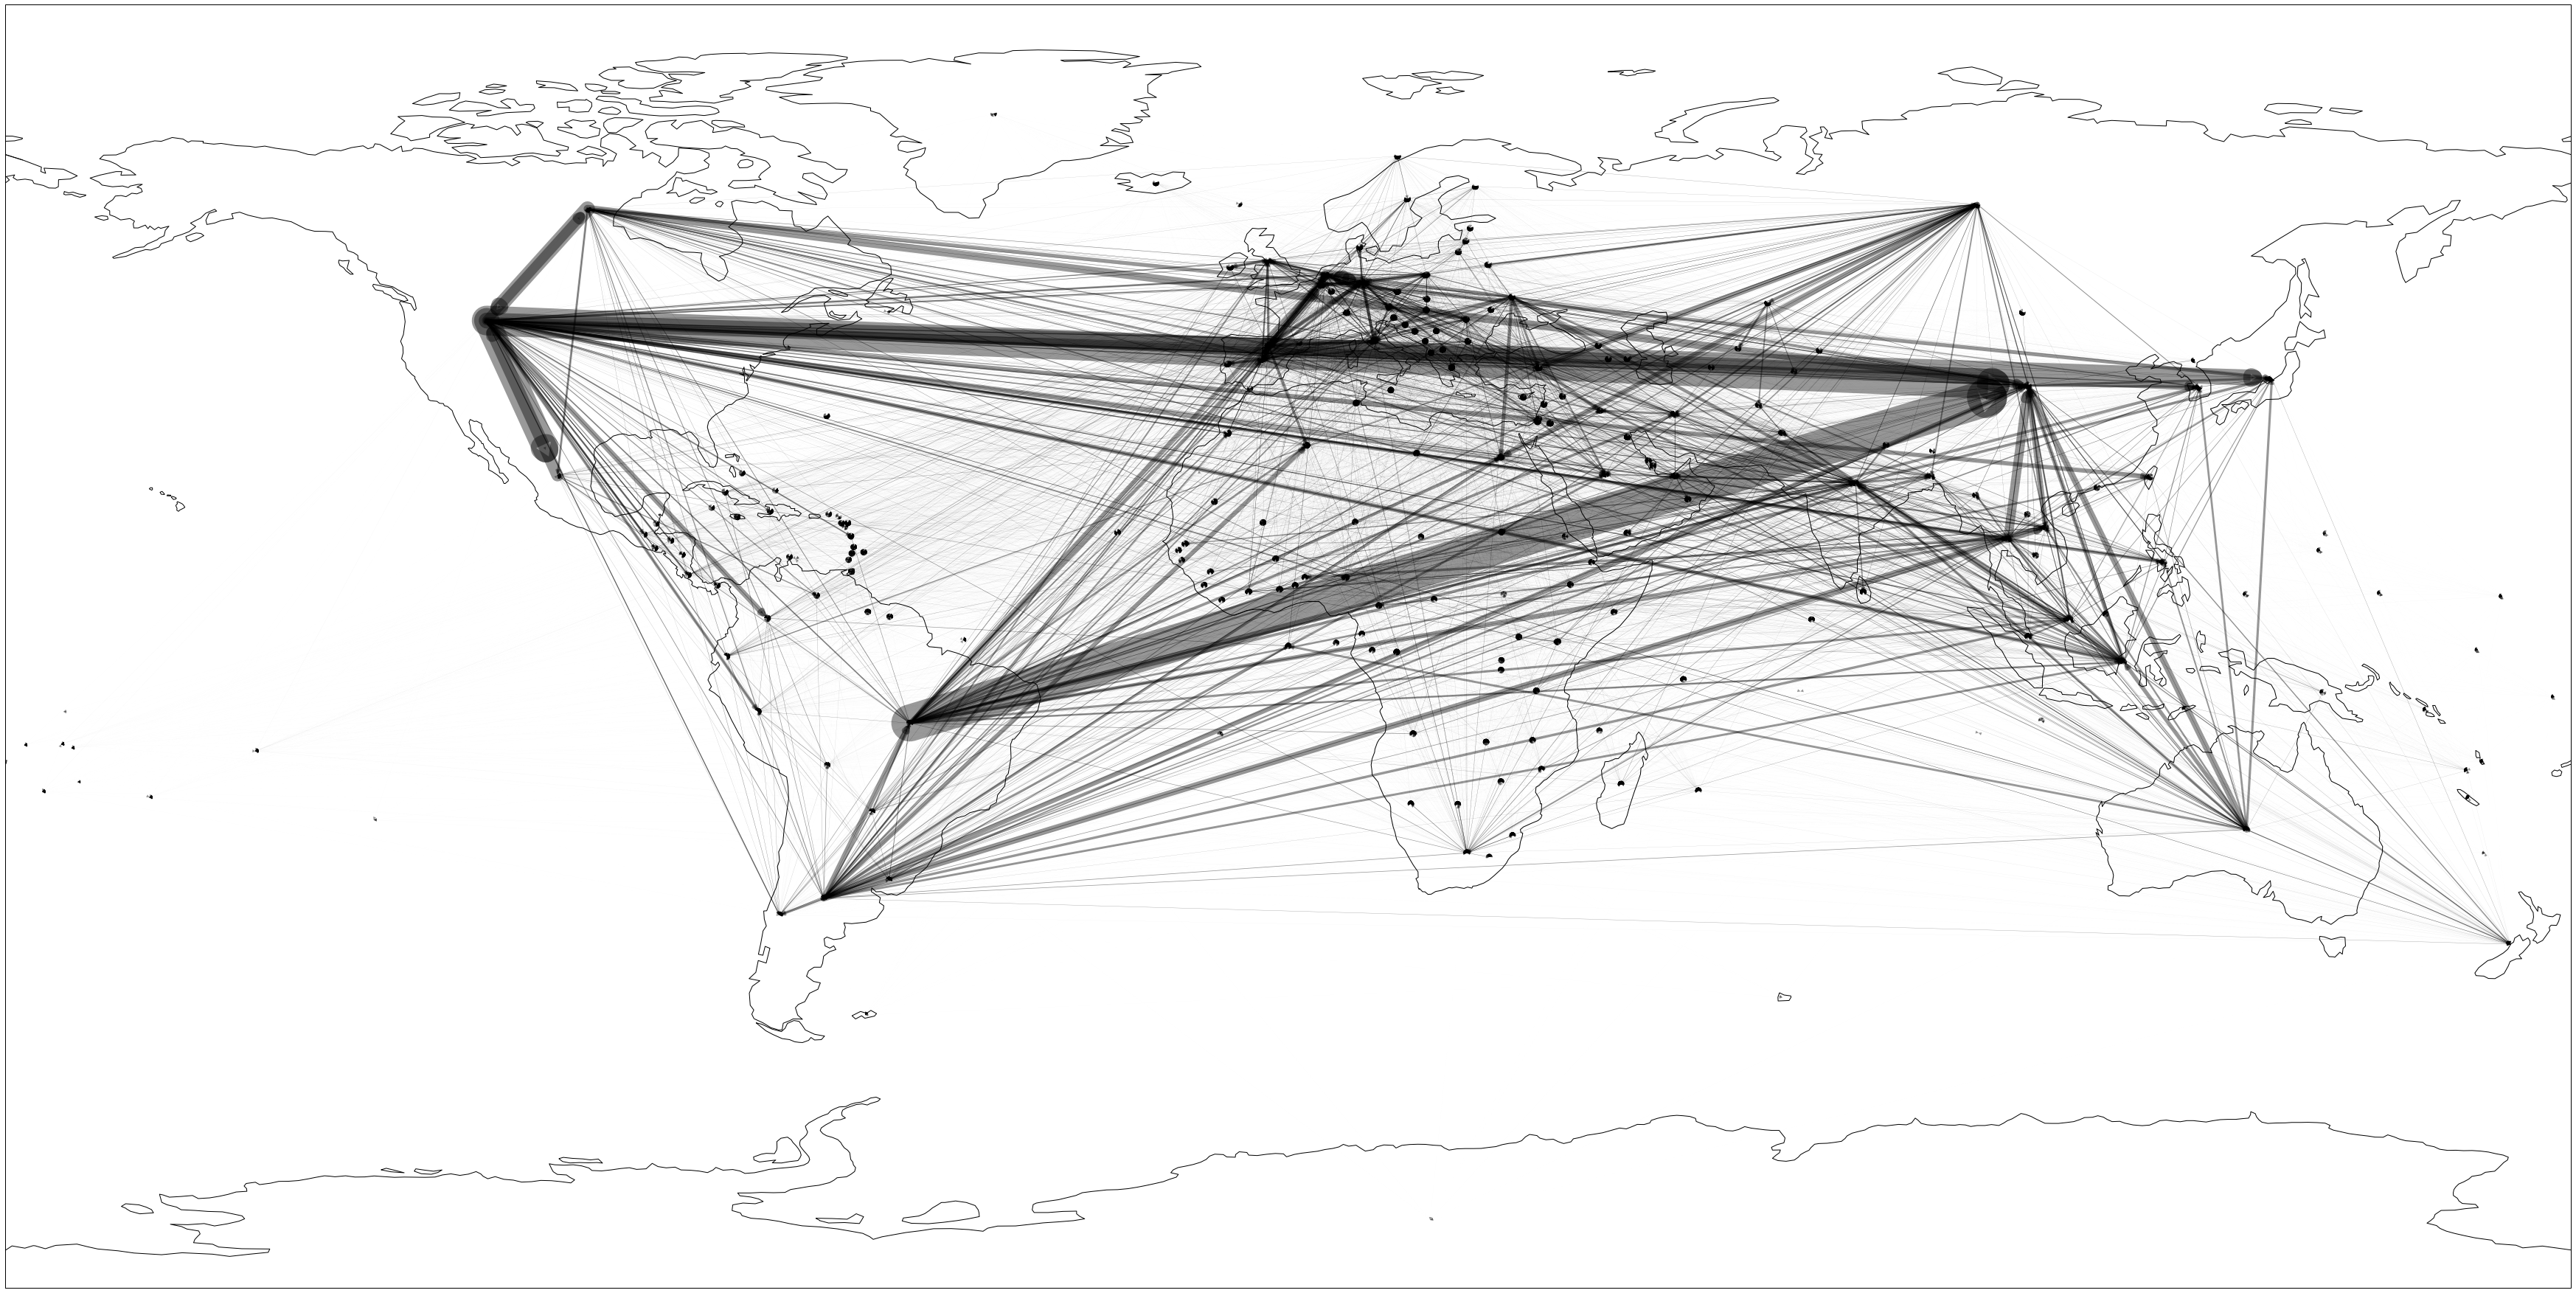

In [36]:
# Project graph onto a map using networkx draw methods
crs = ccrs.PlateCarree()
fig, ax = plt.subplots(
    1, 1, figsize=(72, 32),
    subplot_kw=dict(projection=crs))
ax.coastlines()
nx.draw_networkx(
    trade_graph, 
    ax=ax,
    font_size=16,
    alpha=.4,
    width=weights,
    node_size=0,
    with_labels=False,
    pos=pos,
#     edge_color=weights,
    edge_cmap=plt.cm.winter,
)

## Scenario Trade Graph Generation

Now we'll build the code to automatically generate trade graphs for different lists of countries who cut off exports, highlighting resulting deficits using a chloropleth map

Unspecified Area


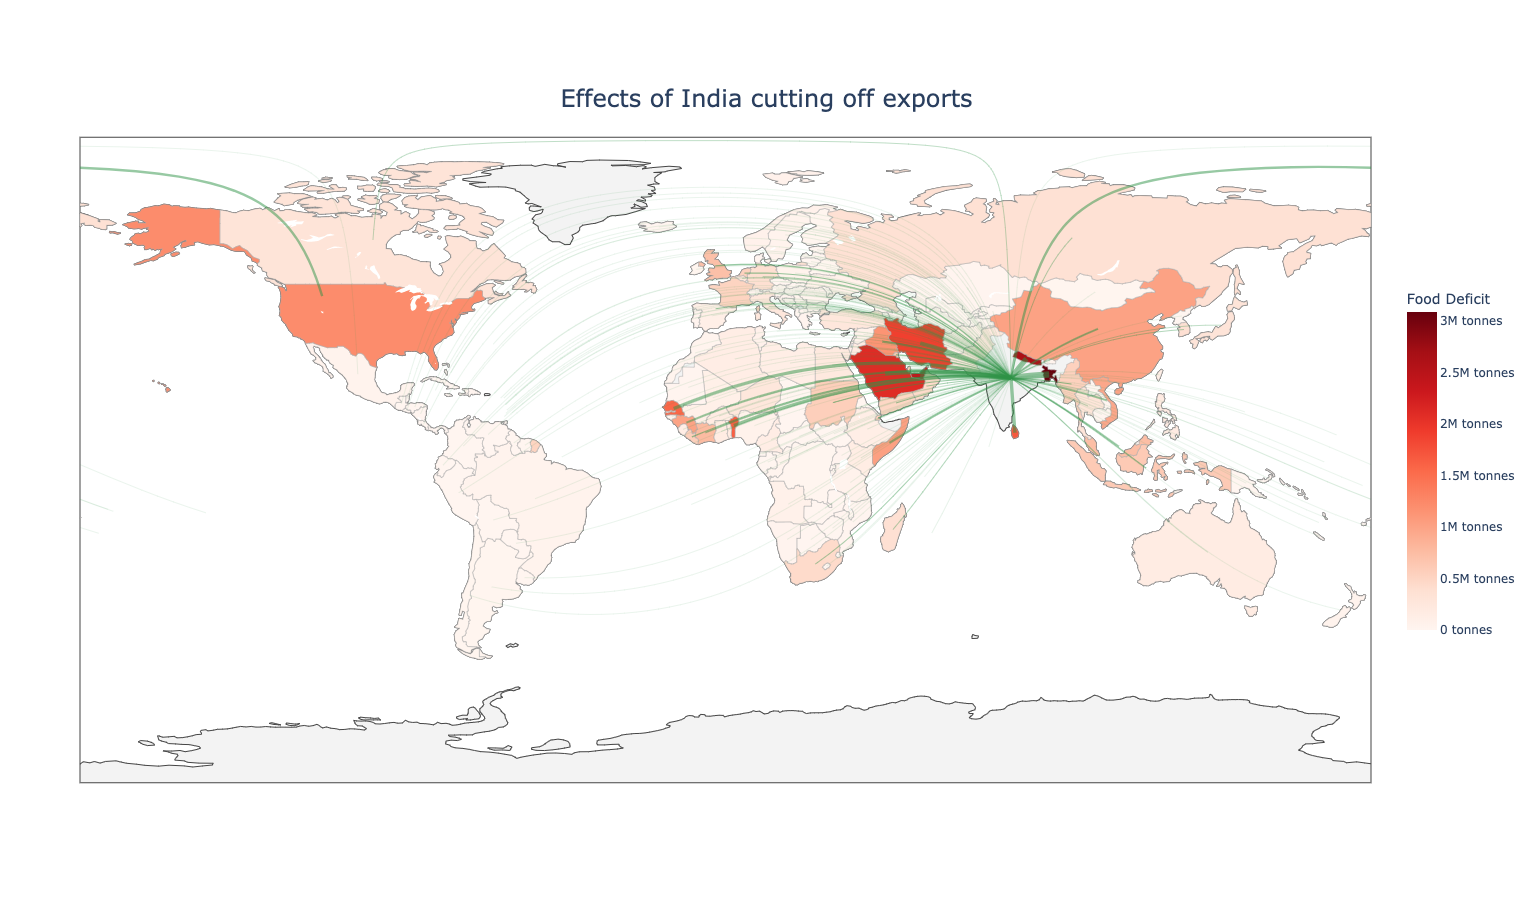

In [167]:
# Choose a list of countries, and a map will be generated showing export trade edges from those countries
# Overlay with a chloropleth map showing total food reduction

country = 'India'  # start with modelling one

export_partners = pd.DataFrame({
    'name': [e[1] for e in trade_graph.out_edges(country)],
    'iso_alpha': [get_iso_alpha_from_country_name(e[1]) for e in trade_graph.out_edges(country)],
    'amount': [trade_graph.get_edge_data(country, e[1])['amount'] for e in trade_graph.out_edges(country)]
})


fig = go.Figure(
    data=go.Choropleth(
        locations = export_partners['iso_alpha'],
        z = export_partners['amount'],
        text = export_partners['name'],
        colorscale = 'Reds',
        autocolorscale=False,
        marker_line_color='darkgray',
        marker_line_width=0.5,
        colorbar_ticksuffix = ' tonnes',
        colorbar_title = 'Food Deficit',
        colorbar_len = 0.5,
        colorbar_title_font_size=14
    )
)

amounts = [trade_graph[u][v]['amount'] for u,v in trade_graph.edges()]
max_amount = max(amounts)

def get_trade_line_width(u, v):
    amount = trade_graph[u][v]['amount']
    return max(amount/5e5, 0.2)


for u, v in trade_graph.edges():
    if u == country:
        fig.add_trace(
            go.Scattergeo(
                lon = [get_lon_lat_from_country_name(u)[0], get_lon_lat_from_country_name(v)[0]],
                lat = [get_lon_lat_from_country_name(u)[1], get_lon_lat_from_country_name(v)[1]],
                mode = 'lines',
                line = dict(width = get_trade_line_width(u, v) ,color = '#2E9246'),
                opacity = 0.5,
#                 hoverinfo = 'text',
#                 hovertext = trade_graph.get_edge_data(u, v)['amount']
            )
        )

fig.update_layout(
#     title_text=f"Effects of {', '.join(countries)} cutting off exports",
    title_font_size=24,
    title={
        'text': f"Effects of {country} cutting off exports",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    width=1500,
    height=900,
    showlegend = False,
    geo = dict(
        showland = True,
        landcolor = 'rgb(243, 243, 243)',
        countrycolor = 'rgb(204, 204, 204)',
    ),
)

fig.show()



## Vulnerability Data Generation

In [59]:
# Load trade table saved from Google Sheet found at
# https://docs.google.com/spreadsheets/d/1xGa_SvD9t1YkuXUweLVArU-AXhRgS-0brgYfGAKUNTg/edit#gid=1461962037

trade_table = pd.read_csv('../data/allfed-trade-table-20202803.csv')
trade_table.columns = ['country', 'production', 'imports', 'exports', 'population']
trade_table['iso_alpha'] = trade_table.country.map(get_iso_alpha_from_country_name)
trade_table['production'] = trade_table.production.apply(lambda p: int(p.replace(',', '')))
trade_table['imports'] = trade_table.imports.apply(lambda p: int(p.replace(',', '')))
trade_table['exports'] = trade_table.exports.apply(lambda p: int(p.replace(',', '')))
trade_table['population'] = trade_table.population.apply(lambda p: int(p.replace(',', '')))
trade_table['longitude'] = trade_table.country.apply(lambda p: get_lon_lat_from_country_name(p)[0])
trade_table['latitude'] = trade_table.country.apply(lambda p: get_lon_lat_from_country_name(p)[1])
trade_table['reduction'] = 0  # perturbation value driven from scenarios
trade_table['deficit'] = 0  # net food deficit driven from scenarios. taken from reduction, plus net exports
trade_table.sample(5)

country  production  imports   exports  \
19   Bolivia (Plurinational State of)    30169611  1043739   1830035   
24                           Bulgaria    39811699  3022657   9194655   
69                            Hungary    64951636  4799558  15625518   
49                        El Salvador    12913707  2915103   1432306   
155       United Republic of Tanzania    90766883  1683443   1205923   

     population iso_alpha  longitude   latitude  reduction  deficit  
19     11192854       BOL -64.685386 -16.708148          0        0  
24      7075947       BGR  25.215529  42.768903          0        0  
69      9787966       HUN  19.395591  47.162775          0        0  
49      6388122       SLV -88.871645  13.739437          0        0  
155    54663906       TZA  34.813100  -6.275654          0        0